<a href="https://colab.research.google.com/github/OdysseusPolymetis/AI_DH_Concordia/blob/main/AI_DH_Concordia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sentence-transformers
!git clone https://github.com/diyclassics/spacy-lookups-data.git
!pip install -r /content/spacy-lookups-data/requirements.txt
!python -m pytest /content/spacy-lookups-data/spacy_lookups_data
!pip install "la-core-web-lg @ https://huggingface.co/latincy/la_core_web_lg/resolve/main/la_core_web_lg-any-py3-none-any.whl"
!git clone https://github.com/PerseusDL/treebank_data.git
!git clone https://github.com/PerseusDL/canonical-latinLit.git

In [1]:
import os
import re
import unicodedata
from collections import defaultdict, Counter
import random

import numpy as np
import cupy as cp  # si vous souhaitez faire certains calculs GPU via numpy-like
import torch
import torch.nn.functional as F

from scipy.stats import chi2_contingency
from lxml import etree
from tqdm import tqdm
import spacy
from sentence_transformers import SentenceTransformer


In [2]:

# --------------------------------------------------------------------
# 1. Préparation des fonctions de nettoyage et de segmentation
# --------------------------------------------------------------------
nlp = spacy.load('la_core_web_lg', disable=["parser", "ner", "lemmatizer", "textcat"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def normalize_text(text):
    # Normaliser (NFC), toLower
    text = unicodedata.normalize('NFC', text)
    return text.lower()

def clean_segment(segment):
    # Supprimer le contenu entre crochets
    segment = re.sub(r'\[.*?\]', '', segment)
    # Supprimer les références abrégées (ex : adv., math., etc.)
    segment = re.sub(r'\b(?:adv|math|vgl|phil|of|vol|p)\.\b', '', segment, flags=re.IGNORECASE)
    # Supprimer les chiffres
    segment = re.sub(r'\d+', '', segment)
    # Supprimer la ponctuation non pertinente
    segment = re.sub(r'[^\w\s]', '', segment)
    # Remplacer les suites d'espaces par un seul espace
    segment = re.sub(r'\s+', ' ', segment)
    return segment.strip()

def segment_latin_text(text, max_batch_size=2048):
    """
    Segmente un texte latin en "fenêtres" de mots,
    en s'appuyant sur la détection SCONJ, CCONJ, PUNCT pour couper.
    """
    segments = []
    text_batches = [text[i:i + max_batch_size] for i in range(0, len(text), max_batch_size)]
    current_segment = []

    for batch in tqdm(text_batches, desc="Traitement des segments latins"):
        doc = nlp(batch)
        for token in doc:
            current_segment.append(token.text)
            # Segmentation "basique"
            if token.pos_ in ['SCONJ', 'CCONJ', 'PUNCT']:
                if len(current_segment) >= 5:
                    segments.append(' '.join(current_segment))
                current_segment = []
        # Fin du batch: si le segment courant a au moins 5 tokens, on l'ajoute
        if len(current_segment) >= 5:
            segments.append(' '.join(current_segment))
        current_segment = []

    return segments

def segment_greek_text(tree):
    """
    Segmente un TEI tree (grec) en fenêtres via postag
    (ex: si postag commence par C ou U => conj / ponct).
    """
    segments = []
    current_segment = []

    for word in tree.findall(".//word"):
        form = word.get("form")
        postag = word.get("postag")
        if form:
            current_segment.append(form)
            if postag and postag[0].lower() in ['c', 'u']:
                if len(current_segment) >= 5:
                    segments.append(' '.join(current_segment))
                current_segment = []

    if len(current_segment) >= 5:
        segments.append(' '.join(current_segment))

    return segments

# --------------------------------------------------------------------
# 2. Extraction des textes depuis les dossiers
# --------------------------------------------------------------------
def extract_body_content_from_xml(file_path):
    parser = etree.XMLParser(recover=True)
    tree = etree.parse(file_path, parser)
    nsmap = tree.getroot().nsmap
    default_ns = nsmap.get(None)

    if default_ns:
        body = tree.find(".//{{{}}}body".format(default_ns))
    else:
        body = tree.find(".//body")

    if body is None:
        raise ValueError(f"No <body> element found in {file_path}")

    text = ''.join(body.itertext())
    # On segmente selon la langue
    if 'grc' in file_path:
        return segment_greek_text(tree)
    else:
        return segment_latin_text(text)

def extract_texts_from_directory(directory_path, target_authors, lang='la'):
    """
    Parcourt un répertoire, extrait les fenêtres (segments) de fichiers .xml
    dont les noms contiennent l'auteur ciblé.
    Retourne : un dict { nom_de_fichier : [fenêtres nettoyées] }
    """
    texts = {}
    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.xml'):
                file_path = os.path.join(root, file)
                # Filtre simpliste sur la langue & auteur
                if lang == 'la' and 'perseus-lat' in file and any(author in file for author in target_authors):
                    segments = extract_body_content_from_xml(file_path)
                    cleaned_segments = [clean_segment(s) for s in segments if len(s.split()) >= 5]
                    texts[file] = cleaned_segments

                elif lang == 'grc' and any(author in file for author in target_authors):
                    segments = extract_body_content_from_xml(file_path)
                    cleaned_segments = [clean_segment(s) for s in segments if len(s.split()) >= 5]
                    texts[file] = cleaned_segments
    return texts

# --------------------------------------------------------------------
# 3. Calcul du LLR (Log-Likelihood Ratio)
# --------------------------------------------------------------------
def calculate_llr_torch(observed):
    """
    observed : torch.Tensor shape=(2,2)
    Calcule le LLR = 2 * chi2, en s'inspirant du chi2 de Pearson.
    """
    expected = observed.sum(dim=1, keepdim=True) * observed.sum(dim=0, keepdim=True) / observed.sum()
    chi2 = torch.sum((observed - expected) ** 2 / (expected + 1e-9))  # +1e-9 pour éviter /0
    return 2 * chi2

# --------------------------------------------------------------------
# 4. Extraction des corpus & calcul du LLR
# --------------------------------------------------------------------
grc_target_authors = ["tlg0012"]
lat_target_authors = ["phi690", "phi0959", "phi0893", "phi0917", "phi1020",
                      "phi0620", "phi1345", "phi1035", "phi0660", "phi0550",
                      "phi1212", "phi0472", "phi1294", "phi1276", "phi0119",
                      "phi0134", "phi0474"]

# Récupération
greek_corpus = extract_texts_from_directory('/content/treebank_data/v2.1/Greek/texts',
                                            grc_target_authors, lang='grc')
latin_corpus = extract_texts_from_directory('/content/canonical-latinLit',
                                            lat_target_authors, lang='la')

# On créé des tuples (segment, file_id)
greek_windows = [(seg, file_id) for file_id, segs in greek_corpus.items() for seg in segs if seg.strip()]
latin_windows = [(seg, file_id) for file_id, segs in latin_corpus.items() for seg in segs if seg.strip()]

# Pour le calcul du LLR
author_windows = defaultdict(list)
for window, author in latin_windows:
    author_windows[author].append(window)

# Fréquences globales (tous auteurs confondus)
window_global_freq = Counter()
for window, _ in latin_windows:
    window_global_freq[window] += 1

total_windows_corpus = len(latin_windows)
llr_scores = []

with tqdm(total=total_windows_corpus, desc="Calculating LLR for all windows") as pbar:
    for author, windows in author_windows.items():
        window_counts = Counter(windows)
        total_target = len(windows)  # nb de fenêtres pour cet auteur
        total_others = total_windows_corpus - total_target

        for window in windows:
            f_target = window_counts[window]
            f_others = window_global_freq[window] - f_target

            # Contingence 2x2
            contingency_table = torch.tensor([
                [f_target,                 f_others],
                [total_target - f_target, total_others - f_others]
            ], dtype=torch.float32, device=device)

            llr_score = calculate_llr_torch(contingency_table)
            llr_scores.append((llr_score.item(), window, author))
            pbar.update(1)

# --------------------------------------------------------------------
# 5. Sélection des fenêtres "pertinentes" (top LLR)
# --------------------------------------------------------------------
author_sorted_windows = defaultdict(list)
for score, window, author in llr_scores:
    author_sorted_windows[author].append((score, window))

num_windows_per_author = 500
selected_windows = []
for author, windows in author_sorted_windows.items():
    # Tri par LLR décroissant
    windows.sort(reverse=True, key=lambda x: x[0])
    unique_windows = set()
    author_selected_windows = []

    for score, window in windows:
        if window not in unique_windows:
            author_selected_windows.append((window, author))
            unique_windows.add(window)
            if len(author_selected_windows) >= num_windows_per_author:
                break
    selected_windows.extend(author_selected_windows)

# On redéfinit nos "latin_windows" comme étant seulement ces fenêtres filtrées
latin_windows = selected_windows

# Petit échantillon pour debug
sampled_windows = random.sample(selected_windows, 5)
for w, a in sampled_windows:
    print(f"[DEBUG] Auteur: {a}, Fenêtre: {w}")

# On fait pareil côté grec, si besoin
greek_windows_selected = [(w, f) for w, f in greek_windows if len(w.split()) >= 5]
latin_windows_selected = [(w, a) for w, a in latin_windows if len(w.split()) >= 5]

# --------------------------------------------------------------------
# 6. Encodage via SentenceTransformer + Similarité
# --------------------------------------------------------------------
model = SentenceTransformer("bowphs/SPhilBerta").to(device)

def compute_embeddings_sphilberta(text_windows, batch_size=512):
    """
    Encode les fenêtres par batch et renvoie un NumPy array d'embeddings.
    On utilise un cache dict pour éviter de re-calculer l'embedding de la même
    phrase plusieurs fois si elle apparaît plusieurs fois.
    """
    cache = {}
    embeddings = []
    to_encode = []

    # On construit une liste des fenêtres à encoder, tout en vérifiant le cache
    for tw in text_windows:
        if tw not in cache:
            to_encode.append(tw)

    # Encodage par batch
    with torch.no_grad():
        for i in tqdm(range(0, len(to_encode), batch_size), desc="Computing embeddings"):
            batch = to_encode[i:i + batch_size]
            batch_embeddings = model.encode(batch, convert_to_tensor=True, device=device)
            # On stocke dans le cache
            for text, emb in zip(batch, batch_embeddings):
                cache[text] = emb.cpu().numpy()

    # Maintenant, on produit la liste finale des embeddings dans l'ordre des `text_windows`
    for tw in text_windows:
        embeddings.append(cache[tw])

    # On retourne un array (N, D)
    return np.vstack(embeddings)

# Embeddings grecs & latins
greek_texts = [w for w, _ in greek_windows_selected]
latin_texts = [w for w, _ in latin_windows_selected]

greek_embeddings = compute_embeddings_sphilberta(greek_texts)
latin_embeddings = compute_embeddings_sphilberta(latin_texts)


Calculating LLR for all windows: 100%|██████████| 249156/249156 [00:53<00:00, 4649.12it/s]


[DEBUG] Auteur: phi0474.phi030.perseus-lat2.xml, Fenêtre: solet is dicere in eum qui pecuniam redegit qui in illum cuius nomine ea pecunia redigeretur non dixerit
[DEBUG] Auteur: phi0119.phi020.perseus-lat2.xml, Fenêtre: qui quod dedit id oblitust datum
[DEBUG] Auteur: phi0474.phi005.perseus-lat2.xml, Fenêtre: quem minime expediat esse in eoeo om
[DEBUG] Auteur: phi0119.phi011.perseus-lat2.xml, Fenêtre: in portu illi ambulo
[DEBUG] Auteur: phi0474.phi009.perseus-lat2.xml, Fenêtre: itinera quae per hoscehosce hos H annos in Italia per agros atque


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Computing embeddings: 100%|██████████| 81/81 [00:15<00:00,  5.20it/s]


In [3]:

# --------------------------------------------------------------------
# 7. Calcul vectorisé des similarités
# --------------------------------------------------------------------
"""
Nous avons :
- greek_embeddings : shape (G, dim)
- latin_embeddings : shape (L, dim)

On veut calculer la similarité cosinus pour (L, G) paires.

Méthode vectorisée via PyTorch :

similarities = F.cosine_similarity(
    torch.tensor(latin_embeddings).unsqueeze(1),
    torch.tensor(greek_embeddings).unsqueeze(0),
    dim=-1
)
=> shape (L, G)
"""

batch_size = 128
similarity_scores = []

latin_t = torch.tensor(latin_embeddings, dtype=torch.float32, device=device)
greek_t = torch.tensor(greek_embeddings, dtype=torch.float32, device=device)

# Pour éviter l'explosion mémoire, on calcule par chunk (batch)
L = latin_t.shape[0]
G = greek_t.shape[0]

with torch.no_grad():
    # On fera un array numpy final
    similarity_scores = np.zeros((L, G), dtype=np.float32)

    for start_l in tqdm(range(0, L, batch_size), desc="Computing similarity by chunk"):
        end_l = min(start_l + batch_size, L)
        # Sous-partie latine
        lat_chunk = latin_t[start_l:end_l]  # shape (batch_l, dim)

        # On calcule la similarité avec *toute* la partie grecque possible
        # Mais si G est très grand, on peut aussi chunker le grec
        # Pour la démo, on le fait en un bloc (attention mémoire)
        # Option : on chunk aussi le grec si besoin.

        # shape (batch_l, G)
        sims = F.cosine_similarity(
            lat_chunk.unsqueeze(1),
            greek_t.unsqueeze(0),
            dim=-1
        )
        # On copie dans similarity_scores
        similarity_scores[start_l:end_l, :] = sims.cpu().numpy()

# --------------------------------------------------------------------
# 8. Trouver les paires les plus similaires
# --------------------------------------------------------------------
num_top = 5
flat_indices = np.argsort(similarity_scores, axis=None)[-num_top:]
top_l, top_g = np.unravel_index(flat_indices, similarity_scores.shape)

for idx in range(num_top):
    # On récupère les indices latins / grecs
    l_idx = top_l[idx]
    g_idx = top_g[idx]
    sim = similarity_scores[l_idx, g_idx]

    # Récupération du texte correspondant
    lat_segment = latin_windows_selected[l_idx][0]
    grc_segment = greek_windows_selected[g_idx][0]

    print(f"[TOP {idx+1}] Sim = {sim:.4f}")
    print(f"    Latin: {lat_segment}")
    print(f"    Grec : {grc_segment}\n")

Computing similarity by chunk: 100%|██████████| 322/322 [00:20<00:00, 15.85it/s]


[TOP 1] Sim = 0.9549
    Latin: Cave sis tu istuc dixeris
    Grec : ἀλλ ἄγε μοι τόδε εἰπὲ καὶ

[TOP 2] Sim = 0.9560
    Latin: certe nemini dubium est quin
    Grec : ἐγὼ δ οὔκ οἴομαι εἶναι

[TOP 3] Sim = 0.9595
    Latin: ἀλλὰ αἰεί τινα φῶτα μέγαν
    Grec : ἀλλ αἰεί τινα φῶτα μέγαν καὶ

[TOP 4] Sim = 0.9834
    Latin: οὔ τοι ἀπόβλητ ἐστὶ θεῶν ἐρικυδέα δῶρα
    Grec : οὔ τοι ἀπόβλητ ἐστὶ θεῶν ἐρικυδέα δῶρα ὅσσά κεν αὐτοὶ δῶσιν

[TOP 5] Sim = 1.0000
    Latin: ἑκὼν δ οὐκ ἄν τις ἕλοιτο
    Grec : ἑκὼν δ οὐκ ἄν τις ἕλοιτο



Auteurs latins détectés : ['phi0119', 'phi0134', 'phi0472', 'phi0474', 'phi0550', 'phi0620', 'phi0660', 'phi0893', 'phi0917', 'phi0959', 'phi1020', 'phi1035', 'phi1212', 'phi1276', 'phi1294', 'phi1345']
Top-k average matrix M : mean=0.6867, std=0.0567


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


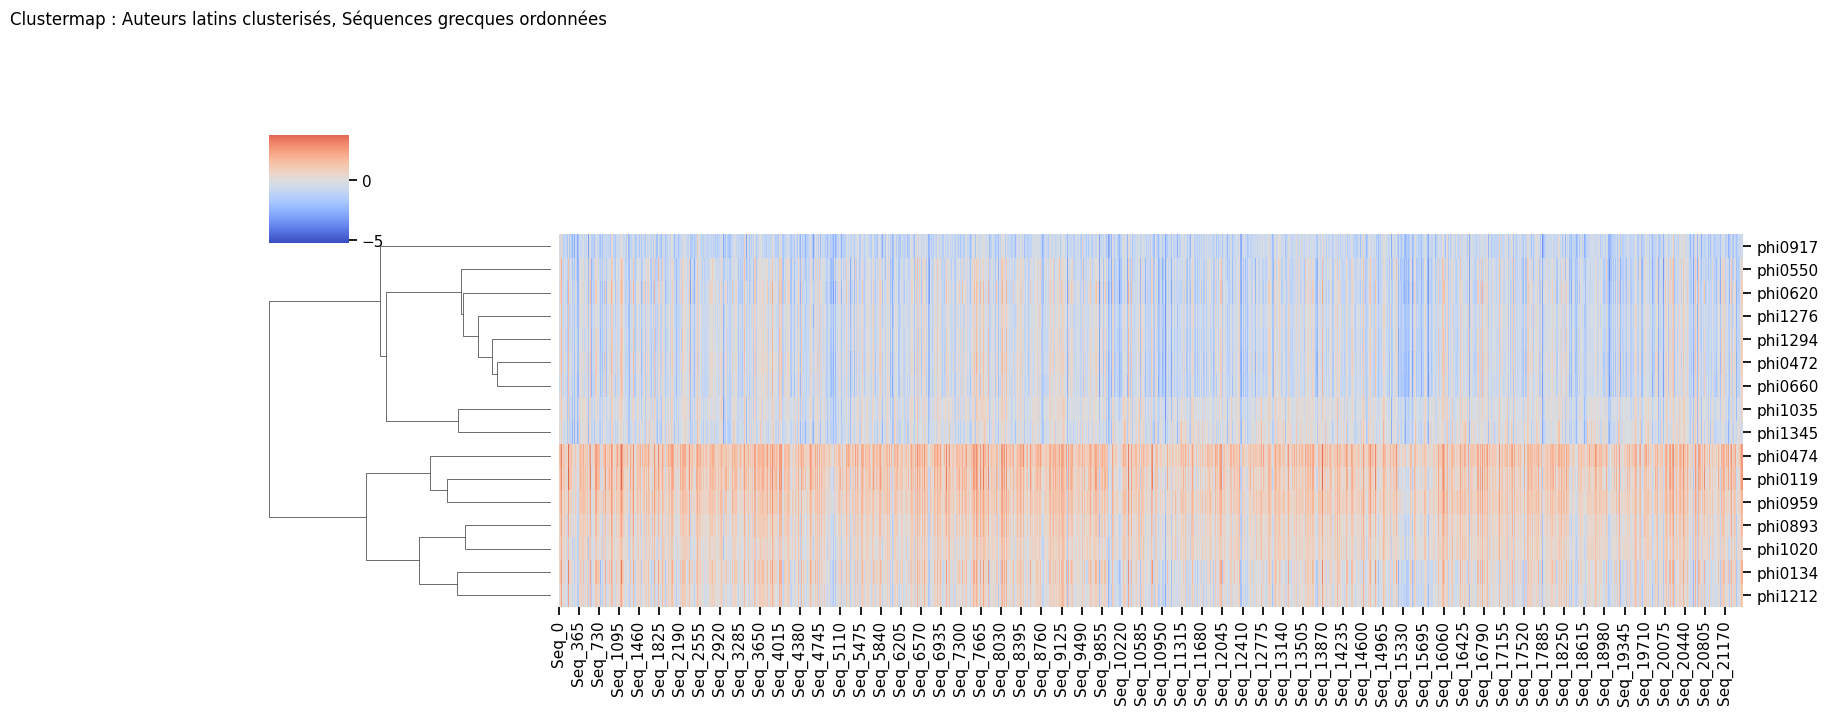

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

##############################################################################
# 0) Fonctions utilitaires / hypothèses
##############################################################################
# similarity_scores : shape = (L, G)
#   L = nb de fenêtres latines
#   G = nb de séquences grecques (dans l'ordre du texte)
# latin_windows_selected = [ (lat_text, lat_file), ... ] => length = L
# greek_windows_selected = [ (grc_text, grc_file), ... ] => length = G
#
# On applique un top‑k average par (AuteurLatin, SéquenceGrecque).

def get_latin_author_id(filename):
    """
    Exemple :
      "phi0959.perseus-lat1.xml" -> "phi0959"
      "phi1294.perseus-lat2.xml" -> "phi1294"
    """
    return filename.split('.')[0]

##############################################################################
# 1) Regrouper les lignes i par Auteur Latin
##############################################################################
latin_author2rowidx = defaultdict(list)
for i, (lat_text, lat_file) in enumerate(latin_windows_selected):
    auth_id = get_latin_author_id(lat_file)
    latin_author2rowidx[auth_id].append(i)

latin_authors = sorted(latin_author2rowidx.keys())
print(f"Auteurs latins détectés : {latin_authors}")

##############################################################################
# 2) Construction de la matrice M (Top-k average)
##############################################################################
k = 50  # paramètre top-k
A = len(latin_authors)  # nb d'auteurs latins
G = len(greek_windows_selected)  # nb de séquences grecques (dans l'ordre naturel)

M = np.zeros((A, G), dtype=np.float32)

for a_idx, author_id in enumerate(latin_authors):
    rows_i = latin_author2rowidx[author_id]  # indices i pour cet auteur

    for j in range(G):
        # On récupère similarity_scores[i, j] pour i in rows_i
        sims = [similarity_scores[i, j] for i in rows_i]
        if len(sims) == 0:
            M[a_idx, j] = 0.0
        else:
            sims.sort(reverse=True)
            top_k_sims = sims[:k]
            M[a_idx, j] = np.mean(top_k_sims)

##############################################################################
# 3) Calcul d'un z-score global sur M
##############################################################################
mu = M.mean()
std = M.std()
Z = np.zeros_like(M)
if std > 1e-9:
    Z = (M - mu) / std

print(f"Top-k average matrix M : mean={mu:.4f}, std={std:.4f}")

##############################################################################
# 4) Construction du DataFrame (lignes=Auteurs, colonnes=Séquences)
#    On conserve l'ordre des séquences tel quel -> col = Seq_0..Seq_{G-1}
##############################################################################
col_names = [f"Seq_{j}" for j in range(G)]  # G séquences dans l'ordre d'apparition
df_z = pd.DataFrame(Z, index=latin_authors, columns=col_names)

##############################################################################
# 5) Clustermap - clusteriser UNIQUEMENT les lignes (row_cluster=True),
#    et préserver l'ordre naturel des colonnes (col_cluster=False)
##############################################################################
sns.set_context("notebook", font_scale=1.0)

g = sns.clustermap(
    df_z,
    cmap="coolwarm",        # palette allant du négatif (bleu) au positif (rouge)
    center=0.0,             # z-score centré sur 0
    row_cluster=True,       # clusteriser les auteurs latins
    col_cluster=False,      # laisser l'ordre des colonnes intact
    metric="euclidean",     # distance pour le clustering des lignes
    method="average",       # ou "complete", "ward", ...
    figsize=(16, 6),
    annot=False
)

# Ajout d'un titre - notez que sur une clustermap, le titre se met souvent
# sous forme "plt.title(...)" après l'appel
plt.title("Clustermap : Auteurs latins clusterisés, Séquences grecques ordonnées", pad=80)
plt.show()

Auteurs latins détectés : ['phi0119', 'phi0134', 'phi0472', 'phi0474', 'phi0550', 'phi0620', 'phi0660', 'phi0893', 'phi0917', 'phi0959', 'phi1020', 'phi1035', 'phi1212', 'phi1276', 'phi1294', 'phi1345']

Fichiers grecs détectés :
  - tlg0012.tlg001  (12302 colonnes)
  - tlg0012.tlg002  (9193 colonnes)


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


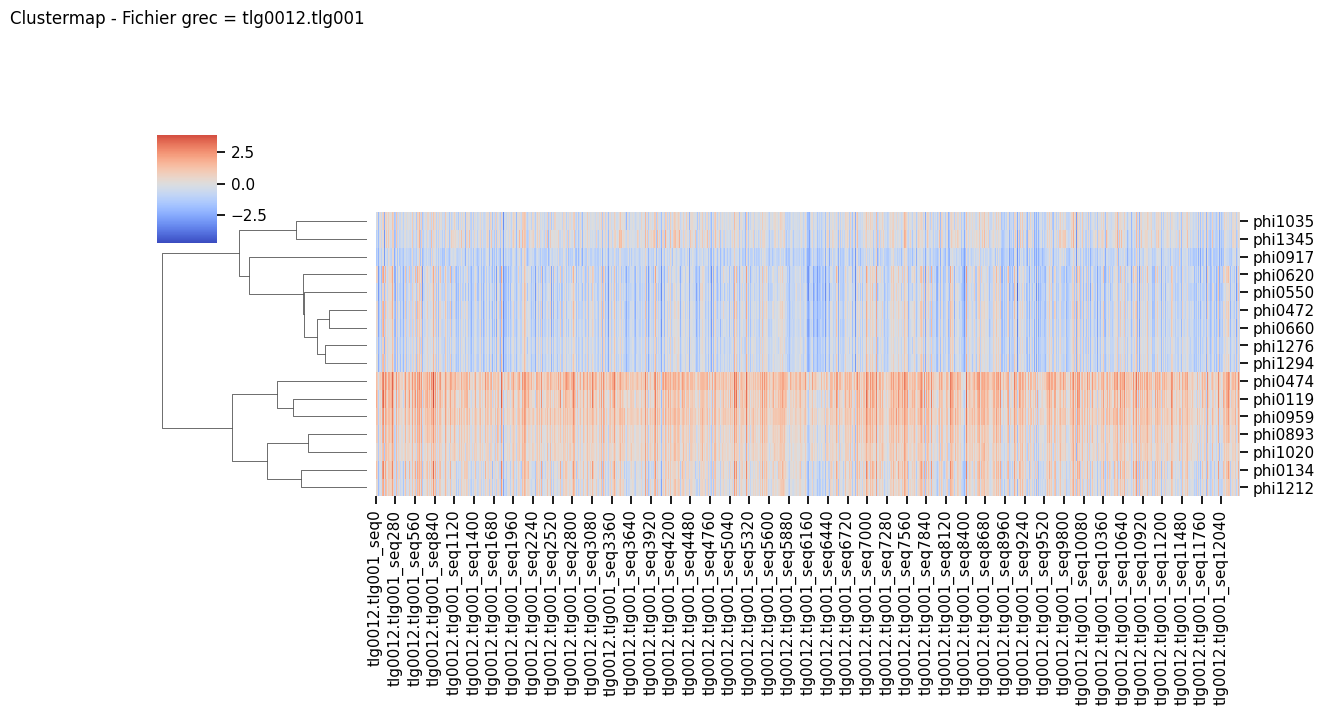

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


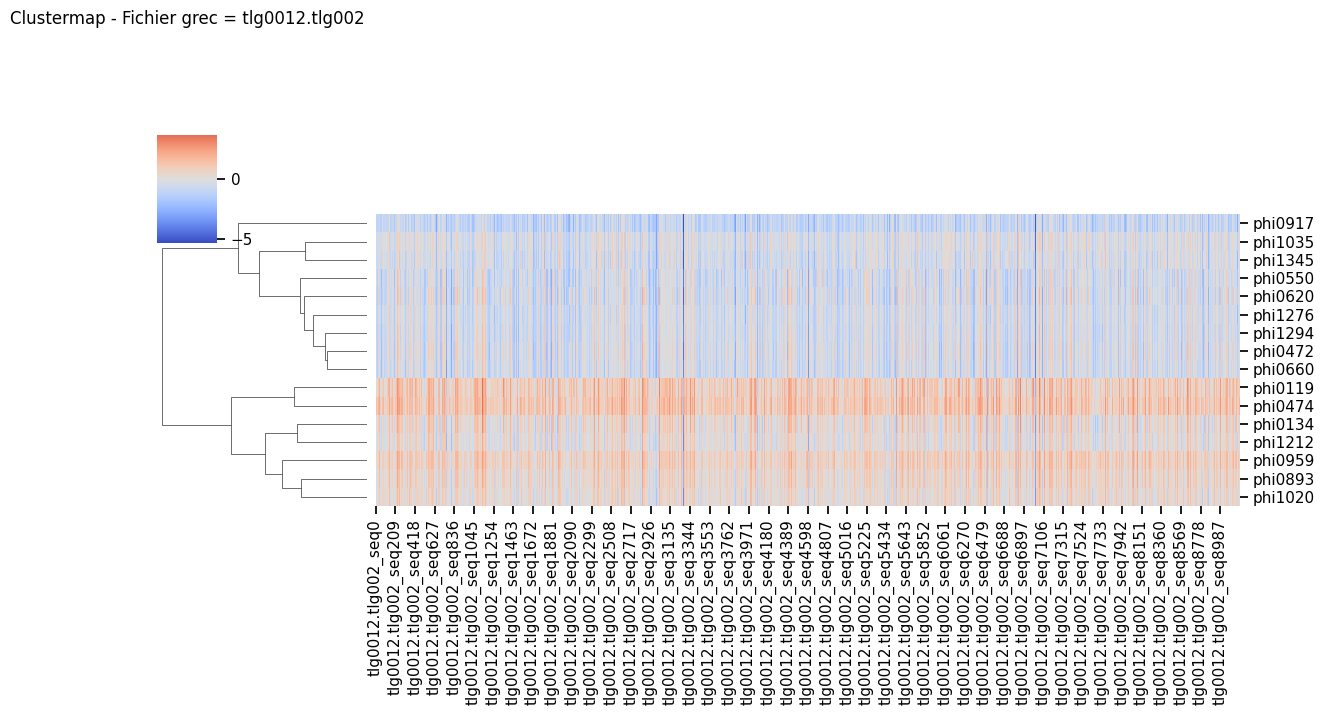

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

##############################################################################
# 1) Fonctions utilitaires
##############################################################################

def get_latin_author_id(filename):
    """
    Extrait l'ID d'auteur latin depuis le nom de fichier.
    Ex: "phi0959.perseus-lat1.xml" -> "phi0959"
    """
    return filename.split('.')[0]

def get_greek_file_id(filename):
    """
    Extrait l'ID de 'fichier grec' (œuvre) depuis le nom de fichier.
    Ex: "tlg0012.tlg001.perseus-grc1.xml" -> "tlg0012.tlg001"
         "tlg0012.tlg002.perseus-grc1.xml" -> "tlg0012.tlg002"
    Adaptez selon votre convention de nommage.
    """
    parts = filename.split('.')
    if len(parts) >= 2:
        return ".".join(parts[:2])  # ex: "tlg0012.tlg001"
    else:
        return filename  # fallback

##############################################################################
# 2) Préparer les regroupements
##############################################################################

# 2a) Regrouper les lignes (i) par auteur latin
latin_author2rowidx = defaultdict(list)
for i, (lat_text, lat_file) in enumerate(latin_windows_selected):
    lat_author = get_latin_author_id(lat_file)
    latin_author2rowidx[lat_author].append(i)

latin_authors = sorted(latin_author2rowidx.keys())
A = len(latin_authors)
print(f"Auteurs latins détectés : {latin_authors}")

# 2b) Regrouper les colonnes (j) par fichier grec
file2cols = defaultdict(list)
for j, (grc_text, grc_file) in enumerate(greek_windows_selected):
    file_id = get_greek_file_id(grc_file)
    file2cols[file_id].append(j)

all_greek_files = sorted(file2cols.keys())
print("\nFichiers grecs détectés :")
for f_id in all_greek_files:
    print(f"  - {f_id}  ({len(file2cols[f_id])} colonnes)")

##############################################################################
# 3) Paramètre top-k (pour le top-k average)
##############################################################################
k = 50  # Ajustez selon la quantité de fenêtres latines typiques de chaque auteur

##############################################################################
# 4) Boucle sur chaque fichier grec -> Construction de la heatmap
##############################################################################

for file_id in all_greek_files:
    cols_j = file2cols[file_id]  # indices de colonnes (séquences) pour ce fichier
    G_local = len(cols_j)        # nombre de séquences grecques dans ce fichier

    # 4a) Construire la matrice locale (A x G_local) => top-k average
    #     A = nb d'auteurs latins, G_local = nb de séquences de CE fichier
    M_sub = np.zeros((A, G_local), dtype=np.float32)

    for a_idx, lat_author in enumerate(latin_authors):
        rows_i = latin_author2rowidx[lat_author]
        for local_col_idx, j_abs in enumerate(cols_j):
            sims = [similarity_scores[i, j_abs] for i in rows_i]
            sims.sort(reverse=True)
            top_sims = sims[:k]
            M_sub[a_idx, local_col_idx] = np.mean(top_sims) if top_sims else 0.0

    # 4b) Calcul d'un z-score (local au fichier)
    mu_sub = M_sub.mean()
    std_sub = M_sub.std()
    Z_sub = np.zeros_like(M_sub)
    if std_sub > 1e-9:
        Z_sub = (M_sub - mu_sub) / std_sub

    # 4c) Construire un DataFrame
    #     Lignes = auteurs latins, Colonnes = séquences du fichier (dans l'ordre)
    #     => On peut nommer les colonnes "seq_0", "seq_1", ... ou plus explicite
    column_names = [f"{file_id}_seq{idx}" for idx in range(G_local)]
    df_z_sub = pd.DataFrame(
        data=Z_sub,
        index=latin_authors,
        columns=column_names
    )

    # 4d) Tracer la clustermap ou heatmap
    #     Ici, on fait un clustermap. On choisit de ne clusteriser que les lignes
    #     pour garder l'ordre naturel des colonnes. Si vous voulez clusteriser
    #     aussi les colonnes, mettez col_cluster=True.
    sns.set_context("notebook", font_scale=1.0)
    g = sns.clustermap(
        df_z_sub,
        cmap="coolwarm",
        center=0.0,          # car c'est un z-score
        metric="euclidean",
        method="average",
        row_cluster=True,    # clusteriser les auteurs
        col_cluster=False,   # conserver l'ordre des colonnes = ordre d'apparition
        figsize=(12, 6),
        annot=False
    )
    plt.title(f"Clustermap - Fichier grec = {file_id}", pad=80)
    plt.show()

In [12]:
# (1) Fonction get_greek_file_id
def get_greek_file_id(filename):
    parts = filename.split('.')
    if len(parts) >= 2:
        return ".".join(parts[:2])
    else:
        return filename

# (2) Filtrer par fichier grec
target_file_id = "tlg0012.tlg002"

subset_greek = []
for j, (g_text, g_file) in enumerate(greek_windows_selected):
    if get_greek_file_id(g_file) == target_file_id:
        subset_greek.append((j, g_text, g_file))

# (3) Sélection des séquences 5 à 10 (exclu) dans ce fichier
start_idx = 1100
end_idx   = 1200
selected_portion = subset_greek[start_idx:end_idx]

# (4) Afficher
for local_idx, (j_abs, g_text, g_file) in enumerate(selected_portion, start=start_idx):
    print(f"=== Séquence locale n°{local_idx} (Index global j={j_abs}) ===")
    print(f"Fichier  : {g_file}")
    print(f"Contenu  : {g_text}\n")

=== Séquence locale n°1100 (Index global j=1100) ===
Fichier  : tlg0012.tlg002.perseus-grc1.tb.xml
Contenu  : οὔ τε μ ἀνάρσιοι ἄνδρες ἐδηλήσαντ ἐπὶ χέρσου

=== Séquence locale n°1101 (Index global j=1101) ===
Fichier  : tlg0012.tlg002.perseus-grc1.tb.xml
Contenu  : μοι Αἴγισθος τεύξας θάνατόν τε μόρον τε ἔκτα σὺν οὐλομένῃ ἀλόχῳ

=== Séquence locale n°1102 (Index global j=1102) ===
Fichier  : tlg0012.tlg002.perseus-grc1.tb.xml
Contenu  : ὥς τίς τε κατέκτανε βοῦν ἐπὶ φάτνῃ

=== Séquence locale n°1103 (Index global j=1103) ===
Fichier  : tlg0012.tlg002.perseus-grc1.tb.xml
Contenu  : περὶ δ ἄλλοι ἑταῖροι νωλεμέως κτείνοντο σύες ὣς ἀργιόδοντες

=== Séquence locale n°1104 (Index global j=1104) ===
Fichier  : tlg0012.tlg002.perseus-grc1.tb.xml
Contenu  : οἵ ῥά τ ἐν ἀφνειοῦ ἀνδρὸς μέγα δυναμένοιο ἢ

=== Séquence locale n°1105 (Index global j=1105) ===
Fichier  : tlg0012.tlg002.perseus-grc1.tb.xml
Contenu  : ἤδη μὲν πολέων φόνῳ ἀνδρῶν ἀντεβόλησας

=== Séquence locale n°1106 (Index global j=1106